In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from pyESN import ESN 

import RSI as rsi
import CPM as cpm
import importlib
import MovingAverage as ma
import Stochastic as st
importlib.reload(ma)
importlib.reload(cpm)
importlib.reload(st)
importlib.reload(rsi)

<module 'RSI' from 'C:\\Users\\jpran\\Capstone\\RSI.py'>

In [2]:
name = 'XOM' 
ticker = yf.Ticker(name)
ori_df = ticker.history(start='2015-07-22', end='2025-07-22', interval='1d', auto_adjust=False)

In [3]:
ori_df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

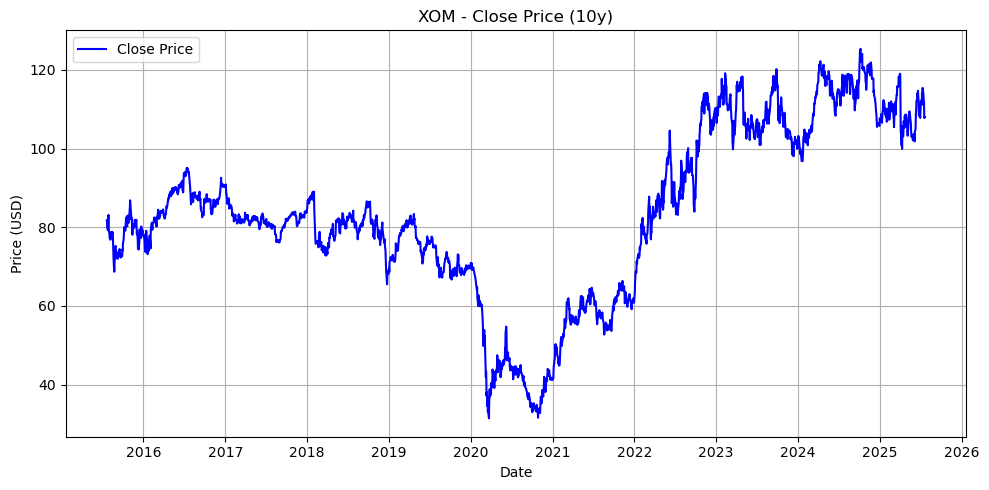

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(ori_df.index, ori_df['Close'], label='Close Price', color='blue')
plt.title(f'{name} - Close Price (10y)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df = ori_df.copy()

In [6]:
cpm_points, df_with_cpm = cpm.cpm_model(df, column='Close',P=0.09, T=5)

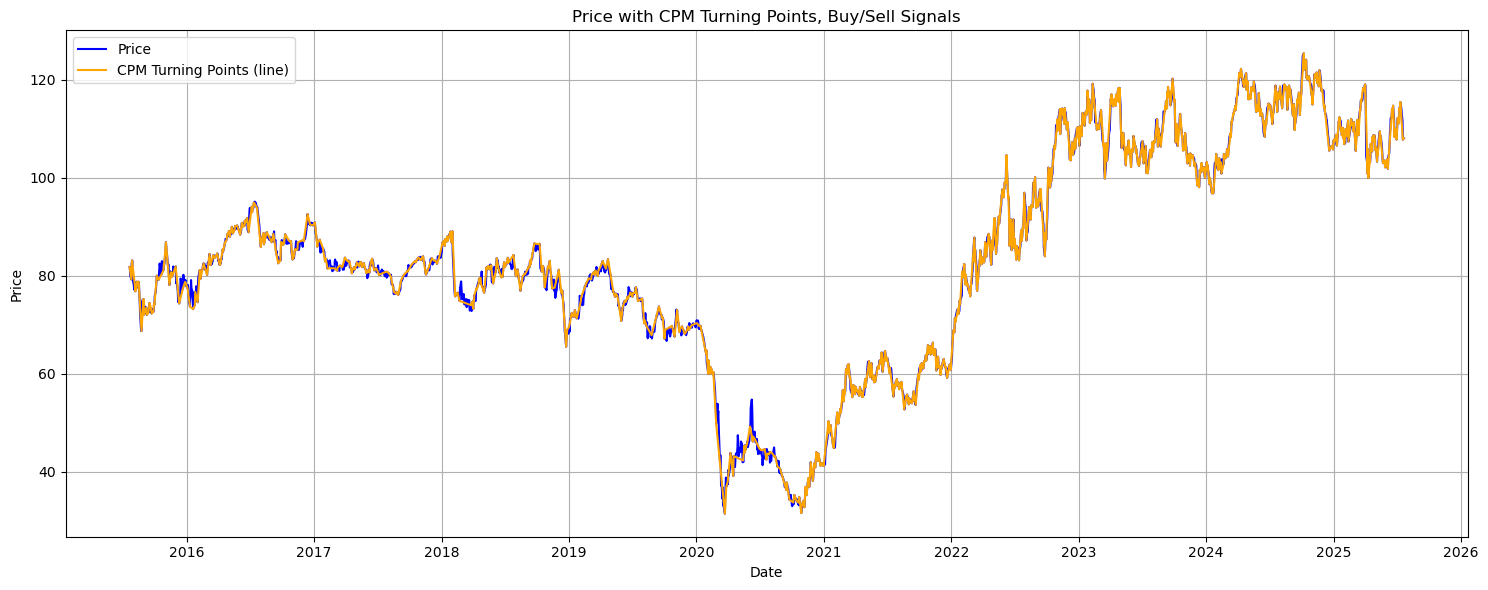

In [7]:
# CPM 신호가 있는 인덱스와 가격
cpm_indices = df_with_cpm[df_with_cpm['is_cpm_point'] == True].index
cpm_prices = df_with_cpm.loc[cpm_indices, 'Close']

# Buy (1) / Sell (-1) 인덱스와 가격
buy_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == 1].index
sell_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == -1].index
buy_prices = df_with_cpm.loc[buy_indices, 'Close']
sell_prices = df_with_cpm.loc[sell_indices, 'Close']

plt.figure(figsize=(15, 6))

# 1. 전체 가격 라인
plt.plot(df.index, df_with_cpm['Close'], label='Price', color='blue')

# 2. CPM 전환점을 선으로 연결
plt.plot(cpm_indices, cpm_prices, label='CPM Turning Points (line)', color='orange')

# 3. Buy 시점 (▲ 초록색)
#plt.scatter(buy_indices, buy_prices, label='Buy Signal', marker='^', color='green', s=100)

# 4. Sell 시점 (▼ 빨간색)
#plt.scatter(sell_indices, sell_prices, label='Sell Signal', marker='v', color='red', s=100)

plt.title("Price with CPM Turning Points, Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
if not isinstance(df_with_cpm.index, pd.DatetimeIndex):
    df_with_cpm.index = pd.to_datetime(df_with_cpm.index)
if df_with_cpm.index.tz is not None:
    df_with_cpm.index = df_with_cpm.index.tz_localize(None)
df_with_cpm.index = df_with_cpm.index.normalize()

In [9]:
total_len = len(df)

train_end = int(total_len * 0.8)
train_df = df_with_cpm.iloc[:train_end]
test_df = df_with_cpm.iloc[train_end:]

In [10]:
ma_best_params, ma_best_fitness, train_df = ma.run_MA_ga_optimization(train_df)

print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

이동평균 유전 알고리즘 실행 중...
gen	nevals	avg    	min   	max    
0  	50    	988.629	966.14	1010.03
1  	40    	983.5  	968.66	1001.17
2  	36    	inf    	963.07	inf    
3  	36    	973.212	963.07	988.4  
4  	32    	972.941	966.83	985.09 
5  	32    	971.417	966.13	983.11 
6  	32    	968.844	966.13	979.92 
7  	40    	968.379	966.13	980.6  
8  	40    	967.836	965.34	985.91 
9  	39    	967.774	964.2 	978.18 
10 	31    	967.169	963.64	972.52 
11 	40    	966.488	961.4 	974.24 
12 	46    	965.369	960.05	974.07 
13 	41    	964.615	960.05	979.84 
14 	37    	963.509	960.05	971.12 
15 	36    	963.207	960.05	978.98 
16 	38    	962.463	960.05	967.29 
17 	41    	961.805	959.85	970.27 
18 	38    	961.418	960.05	975.04 
19 	41    	960.598	960.04	964.79 
20 	36    	960.489	959.85	966.13 
21 	42    	960.407	959.85	968.11 
22 	36    	960.213	959.85	966.32 
23 	35    	960.777	959.85	978.65 
24 	34    	960.018	959.85	961.21 
25 	39    	960.491	959.85	967.31 
26 	41    	960.325	959.85	966.64 
27 	41    	960.519	959.85	9

In [11]:
N, n, a, b, c = ma_best_params

In [12]:
test_ma_signals = ma.generate_MA_signals(test_df, N, n, a, b, c)

In [13]:
signal_map = test_ma_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['MA_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_15440\4009268628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['MA_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [14]:
rsi_best_params, rsi_best_fitness, train_df = rsi.run_RSI_ga_optimization(train_df)

print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

RSI 유전 알고리즘 실행 중...
gen	nevals	avg    	min   	max   
0  	50    	979.395	975.16	979.52
1  	41    	inf    	970.07	inf   
2  	40    	inf    	969.12	inf   
3  	32    	inf    	953.89	inf   
4  	37    	inf    	955.36	inf   
5  	33    	inf    	933.7 	inf   
6  	40    	inf    	933.91	inf   
7  	37    	inf    	940.39	inf   
8  	44    	inf    	936.97	inf   
9  	42    	inf    	934.88	inf   
10 	40    	inf    	936.57	inf   
11 	34    	inf    	935.35	inf   
12 	39    	inf    	924.9 	inf   
13 	36    	inf    	919.24	inf   
14 	38    	inf    	919.24	inf   
15 	41    	inf    	917.54	inf   
16 	42    	inf    	914.87	inf   
17 	33    	inf    	911.55	inf   
18 	34    	inf    	904.99	inf   
19 	41    	inf    	904.99	inf   
20 	46    	inf    	904.09	inf   
21 	33    	922.086	903.95	974.3 
22 	40    	919.833	902.81	974.37
23 	38    	917.486	902.81	974.3 
24 	38    	922.616	902.81	974.3 
25 	46    	922.601	902.81	975.72
26 	38    	916.626	902.81	974.3 
27 	38    	921.444	902.81	974.3 
28 	44    	925.477	902.

In [15]:
x, overbought_level, oversold_level, p, q = rsi_best_params

In [16]:
test_rsi_signals = rsi.generate_RSI_signals(test_df, x, overbought_level, oversold_level, p, q)

503 2.3929429895289624


In [17]:
signal_map = test_rsi_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['RSI_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_15440\1229919477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['RSI_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [18]:
Technical_Signals = ['MA_Signals', 'RSI_Signals']

In [21]:
import ESN_GA
from ESN_GA import run_genetic_algorithm, perform_final_backtest, PARAM_RANGES
importlib.reload(ESN_GA)

<module 'ESN_GA' from 'C:\\Users\\jpran\\Capstone\\ESN_GA.py'>

In [22]:
best_params_ga, ga_log = run_genetic_algorithm(
    train_df_ga=train_df,
    test_df_ga=test_df,
    technical_signals_list=Technical_Signals,
    pop_size=30,
    num_generations=15,
    random_seed=42
)

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

gen	nevals	avg     	std    	min     	max    
0  	30    	-9.67033	20.9424	-64.1727	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

1  	25    	1.9762  	13.634 	-27.8979	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

2  	23    	8.02997 	14.7273	-26.3322	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

3  	28    	5.41835 	16.6412	-30.7592	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

4  	27    	3.2979  	17.5343	-50.2799	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

5  	19    	1.24904 	26.0932	-66.3561	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

6  	21    	10.137  	25.2806	-60.2455	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

7  	30    	21.063  	21.422 	-31.4483	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

8  	21    	30.7542 	15.6296	-14.7448	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

9  	27    	35.1014 	9.1444 	-2.51679	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

10 	25    	37.5328 	0      	37.5328 	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

11 	20    	34.6197 	10.9002	-6.47731	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

12 	23    	34.4262 	12.0226	-20.9586	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

13 	22    	32.8402 	16.5083	-37.7609	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

14 	25    	36.4375 	5.89852	4.67294 	37.5328


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

15 	22    	35.7173 	9.77664	-16.9315	37.5328

GA 최적화 완료 - 최적 하이퍼파라미터: [473, 0.6626540971560848, 0.18408264311148553, 0.6361401395021546]
GA 최적화 완료 - 최고 Return [%]: 37.5328


In [23]:
print(best_params_ga)

[473, 0.6626540971560848, 0.18408264311148553, 0.6361401395021546]


In [24]:
final_backtest_stats, final_signals = perform_final_backtest(
    train_df=train_df,
    test_df=test_df,
    best_params=best_params_ga,
    technical_signals_list=Technical_Signals,
    random_state=42
)


--- 최적화된 파라미터로 최종 ESN 학습 및 백테스팅 ---
  n_reservoir: 473
  spectral_radius: 0.6627
  sparsity: 0.1841
  signal_threshold: 0.6361


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2023-07-19 00:00:00
End                       2025-07-21 00:00:00
Duration                    733 days 00:00:00
Exposure Time [%]                    61.43141
Equity Final [$]                  13753.27972
Equity Peak [$]                   13900.58728
Commissions [$]                    1617.61863
Return [%]                            37.5328
Buy & Hold Return [%]                 6.32749
Return (Ann.) [%]                    17.31154
Volatility (Ann.) [%]                19.60888
CAGR [%]                             11.57915
Sharpe Ratio                          0.88284
Sortino Ratio                         1.60626
Calmar Ratio                          0.93501
Alpha [%]                            34.18462
Beta                                  0.52915
Max. Drawdown [%]                   -18.51476
Avg. Drawdown [%]                    -3.22714
Max. Drawdown Duration      272 days 00:00:00
Avg. Drawdown Duration       36 days 00:00:00
# Trades 

In [27]:
def plot_signals(original_df: pd.DataFrame, signals_df: pd.DataFrame, title: str = "ESN Signals with CPM Points"):
    plt.figure(figsize=(16, 8))
    plt.plot(original_df.index, original_df['Close'], label='Close Price', color='skyblue', linewidth=1.5)

    # ESN 예측 매수 신호 (BUY) 표시
    buy_signals = signals_df[signals_df['Predicted_Signals'] == -1]
    plt.scatter(buy_signals.index, buy_signals['Close'],
                marker='^', color='green', s=100, label='ESN BUY Signal', alpha=0.8, zorder=5)

    # ESN 예측 매도 신호 (SELL) 표시
    sell_signals = signals_df[signals_df['Predicted_Signals'] == 1]
    plt.scatter(sell_signals.index, sell_signals['Close'],
                marker='v', color='red', s=100, label='ESN SELL Signal', alpha=0.8, zorder=5)

    # --- CPM Point Type ---
    if 'cpm_point_type' in original_df.columns:
        cpm_buy_points = original_df[original_df['cpm_point_type'] == -1]
        cpm_sell_points = original_df[original_df['cpm_point_type'] == 1]

        # CPM BUY 포인트
        plt.scatter(cpm_buy_points.index, cpm_buy_points['Close'],
                    marker='D', color='blue', s=120, label='CPM BUY Point', alpha=0.6, zorder=4)

        # CPM SELL 포인트
        plt.scatter(cpm_sell_points.index, cpm_sell_points['Close'],
                    marker='D', color='orange', s=120, label='CPM SELL Point', alpha=0.6, zorder=4)
    else:
        print("경고: 'cpm_point_type' 컬럼이 original_df에 없어 CPM 포인트를 표시할 수 없습니다.")

    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

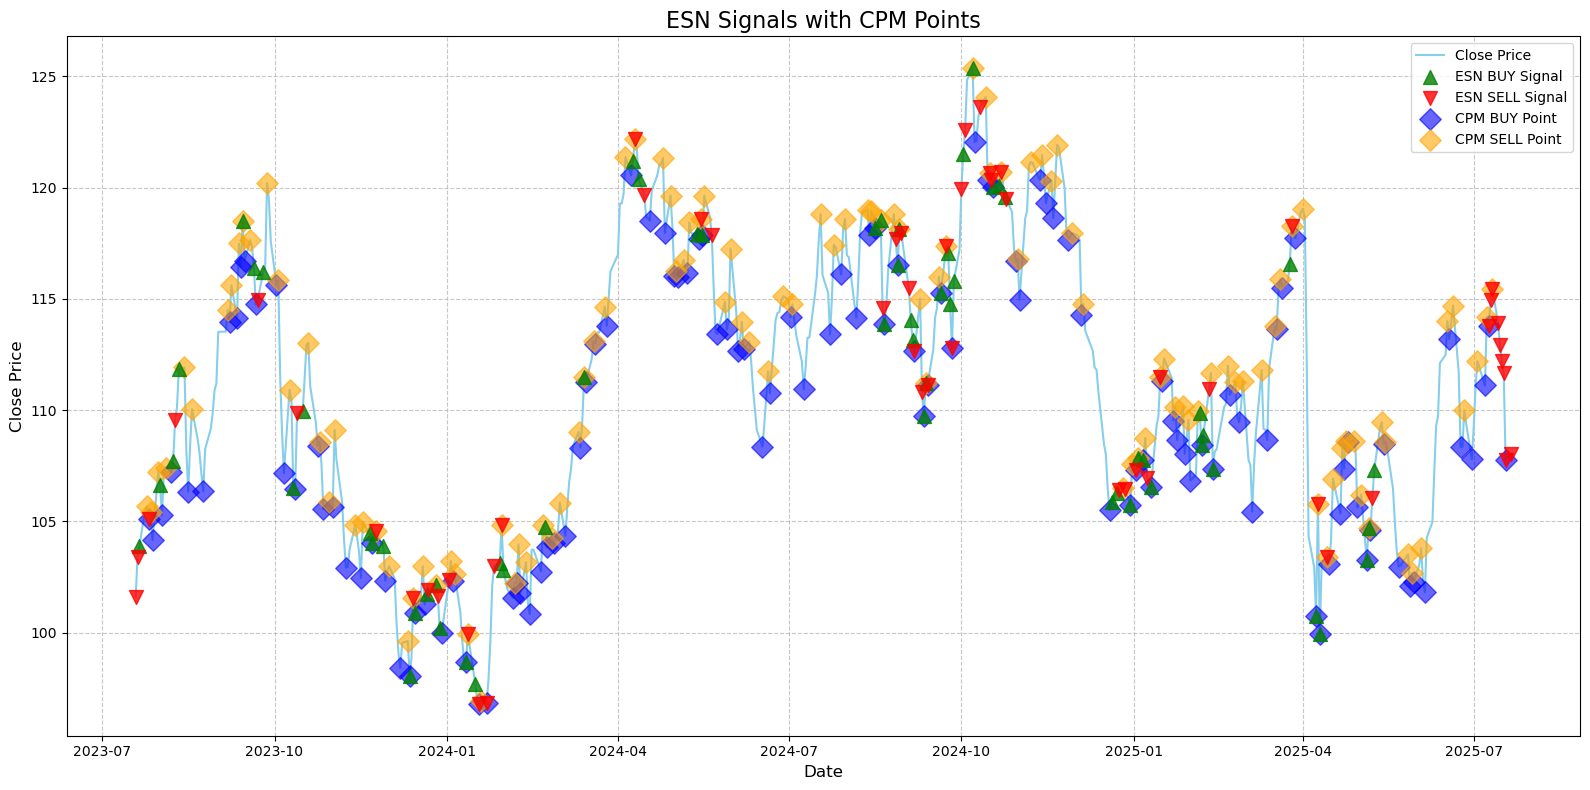

In [26]:
plot_signals(test_df, final_signals)